<a href="https://colab.research.google.com/github/data-science-and-machine-learning/amazon-fine-food-reviews-knn/blob/master/03_Amazon_Fine_Food_Reviews_Analysis_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

from google.colab import files
files.upload()

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d snap/amazon-fine-food-reviews

!unzip amazon-fine-food-reviews.zip -d amazon_fine_food_reviews_data



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Saving kaggle.json to kaggle (1).json
 90% 226M/251M [00:05<00:00, 27.1MB/s]
100% 251M/251M [00:05<00:00, 46.3MB/s]
Archive:  amazon-fine-food-reviews.zip
  inflating: amazon_fine_food_reviews_data/Reviews.csv  
  inflating: amazon_fine_food_reviews_data/database.sqlite  
  inflating: amazon_fine_food_reviews_data/hashes.txt  


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon_fine_food_reviews_data/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 ORDER BY Time ASC""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...


## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
sorted_data=sorted_data[sorted_data.HelpfulnessNumerator<=sorted_data.HelpfulnessDenominator]

In [4]:
#Deduplication of entries
#Due to low availability of RAM I am using only 100000 datapoints for k-NN modeling
#Clamping last 100000 datapoints to get latest reviews
final= sorted_data.tail(100000)
final.shape

(100000, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

19.01813188694101

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100000, 10)


1    82609
0    17391
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [7]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

The Van Ness food mat is a great product.  The edges are raised to prevent water leaks onto your floor/rug, and the material is very easy to clean. I also found that the size is perfect for an automatic feeder, and a decent size water bowl. FIVE STARS!
A meat stick that tastes like Ham & an American cheese food-type stick.<br />I prefer the Ham flavor over the oh-so-salty beef stick.<br />Great to fight hunger pains while biking or backpacking or waiting for your fish to bite your hook.
Great Coffee at a great price.I normally ground it finer and use a percolator which makes it taste better than the regular coffee machines.<br />Too bad amazon stopped selling this item
Due to our cooking habits we use a lot of avocados in preparing our meals.  From Mexican food to salads and sandwiches and of course Guacamole Dip, they are an important part of our dietary intake.  The Guacamole dip is a favorite in our household and my wife has at least six different recipes she prepares it with.  We d

In [8]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

The Van Ness food mat is a great product.  The edges are raised to prevent water leaks onto your floor/rug, and the material is very easy to clean. I also found that the size is perfect for an automatic feeder, and a decent size water bowl. FIVE STARS!


In [9]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

The Van Ness food mat is a great product.  The edges are raised to prevent water leaks onto your floor/rug, and the material is very easy to clean. I also found that the size is perfect for an automatic feeder, and a decent size water bowl. FIVE STARS!
A meat stick that tastes like Ham & an American cheese food-type stick.I prefer the Ham flavor over the oh-so-salty beef stick.Great to fight hunger pains while biking or backpacking or waiting for your fish to bite your hook.
Great Coffee at a great price.I normally ground it finer and use a percolator which makes it taste better than the regular coffee machines.Too bad amazon stopped selling this item
Due to our cooking habits we use a lot of avocados in preparing our meals.  From Mexican food to salads and sandwiches and of course Guacamole Dip, they are an important part of our dietary intake.  The Guacamole dip is a favorite in our household and my wife has at least six different recipes she prepares it with.  We do though use and t

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great Coffee at a great price.I normally ground it finer and use a percolator which makes it taste better than the regular coffee machines.<br />Too bad amazon stopped selling this item


In [12]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

The Van Ness food mat is a great product.  The edges are raised to prevent water leaks onto your floor/rug, and the material is very easy to clean. I also found that the size is perfect for an automatic feeder, and a decent size water bowl. FIVE STARS!


In [13]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great Coffee at a great price I normally ground it finer and use a percolator which makes it taste better than the regular coffee machines br Too bad amazon stopped selling this item


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [15]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:32<00:00, 3050.72it/s]


In [16]:
preprocessed_reviews[1500]

'great coffee great price normally ground finer use percolator makes taste better regular coffee machines bad amazon stopped selling item'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'mae', 'ploy', 'sweet', 'chili', 'sauce', 'becoming', 'standard', 'condiment', 'dinner', 'table']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:03<00:00, 1286.18it/s]

4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:31<00:00, 158.84it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://github.com/data-science-and-machine-learning/amazon-fine-food-reviews-knn/blob/master/train_cv_auc.JPG?raw=1' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://github.com/data-science-and-machine-learning/amazon-fine-food-reviews-knn/blob/master/train_test_auc.JPG?raw=1' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://github.com/data-science-and-machine-learning/amazon-fine-food-reviews-knn/blob/master/confusion_matrix.png?raw=1' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='https://github.com/data-science-and-machine-learning/amazon-fine-food-reviews-knn/blob/master/summary.JPG?raw=1' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

In [0]:
def knn_estimator(X, Y, vectorizer, K, params, cv, scoring, vectname):
  from sklearn.model_selection import KFold, train_test_split, GridSearchCV
  from sklearn.neighbors import KNeighborsClassifier, kd_tree
  import time

  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=False, stratify=None)

  t = time.time()
  train = vectorizer.fit_transform(x_train)
  test = vectorizer.transform(x_test)
  print('Time consumed in {} vectorization= {:.2f} seconds'.format(vectname, time.time()-t))
  
  import multiprocessing
  jobs = multiprocessing.cpu_count()
  t = time.time()
  knn =KNeighborsClassifier()
  parameters = params
  clf = GridSearchCV(knn, parameters, cv=cv, scoring='roc_auc', verbose=10, n_jobs=jobs, return_train_score=True)
  if 'kd_tree' in vectname:
    clf.fit(train.toarray(), y_train)
  else:
    clf.fit(train, y_train)
    
  print('Time consumed in GridsearchCV classifier= {:.2f} seconds'.format(time.time()-t))
  
  train_auc= clf.cv_results_['mean_train_score']
  train_auc_std= clf.cv_results_['std_train_score']
  cv_auc = clf.cv_results_['mean_test_score'] 
  cv_auc_std= clf.cv_results_['std_test_score']

  plt.plot(K, train_auc, label='Train AUC')
  # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
  plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

  plt.plot(K, cv_auc, label='CV AUC')
  # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
  plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
  plt.legend()
  plt.xlabel("K: hyperparameter")
  plt.ylabel("AUC")
  plt.title("ERROR PLOTS")
  plt.show()  
  return clf.cv_results_
  
 k_list = list(range(1, 32, 2))

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [90]:
# Please write all the code with proper documentation
# final datapoint are in list preprocessed_reviews and their label in final['score']
# splitting datapoints to test and train sets
k = k_list
vect =  CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
params = {'n_neighbors':k, 'algorithm': ['brute']}
scoring='roc_auc'
bow_brute_estimations = knn_estimator(preprocessed_reviews, final['Score'], vect, k, params, 3, scoring, 'BoW')

Time consumed in BoW vectorization= 12.80 seconds
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  3.4min


KeyboardInterrupt: ignored

In [0]:
import time

while True:
  print(time.ctime(), end='\r')

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
# final datapoint are in list preprocessed_reviews and their label in final['score']
# splitting datapoints to test and train sets

k = k_list
vect =  TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
params = {'n_neighbors':k, 'algorithm': ['brute']}
scoring='roc_auc'
tfidf_brute_estimations = knn_estimator(preprocessed_reviews, final['Score'], vect, k, params, 3, scoring, 'BoW')

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [18]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
        
        
        
        
        
        
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

[('awesome', 0.8735930323600769), ('fantastic', 0.8544895052909851), ('good', 0.8159528970718384), ('excellent', 0.8128284215927124), ('wonderful', 0.7890537977218628), ('terrific', 0.7610834240913391), ('amazing', 0.7484904527664185), ('perfect', 0.7477741241455078), ('fabulous', 0.7203388214111328), ('nice', 0.6744621992111206)]
[('greatest', 0.8155362010002136), ('tastiest', 0.7765815258026123), ('best', 0.7554215788841248), ('nastiest', 0.7404584288597107), ('strangest', 0.6952078342437744), ('vile', 0.629817545413971), ('closest', 0.6213970184326172), ('disgusting', 0.6136690974235535), ('smoothest', 0.6113415956497192), ('horrible', 0.6062858700752258)]
number of words that occured minimum 5 times  17160
sample words  ['van', 'ness', 'food', 'mat', 'great', 'product', 'edges', 'raised', 'prevent', 'water', 'leaks', 'onto', 'floor', 'rug', 'material', 'easy', 'clean', 'also', 'found', 'size', 'perfect', 'automatic', 'feeder', 'decent', 'bowl', 'five', 'stars', 'managed', 'find', '

100%|██████████| 80000/80000 [02:29<00:00, 534.66it/s]


80000
50
Time consumed in Avg W2V vectorization= 150.60 seconds
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done   4 out of   6 | elapsed:  3.6min remaining:  1.8min
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  5.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:  5.3min finished


Time consumed in GridsearchCV classifier= 317.45 seconds


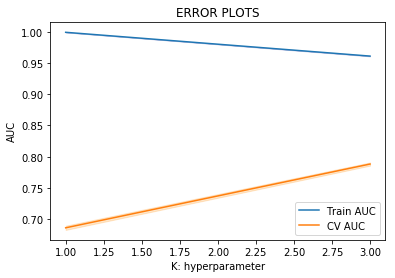

In [96]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, kd_tree
import time

x_train, x_test, y_train, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.20, shuffle=False, stratify=None)

t = time.time()

i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
    

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


print('Time consumed in {} vectorization= {:.2f} seconds'.format('Avg W2V', time.time()-t))


import multiprocessing
jobs = multiprocessing.cpu_count()
t = time.time()
knn =KNeighborsClassifier()
parameters = {'n_neighbors':k_list, 'algorithm': ['brute']}
clf = GridSearchCV(knn, parameters, cv=3, scoring='roc_auc', verbose=10, n_jobs=jobs, return_train_score=True)
clf.fit(sent_vectors, y_train)
print('Time consumed in GridsearchCV classifier= {:.2f} seconds'.format(time.time()-t))

avgw2v_brute_estimations = clf.cv_results_

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()  

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, kd_tree
import time

x_train, x_test, y_train, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.20, shuffle=False, stratify=None)

t = time.time()

i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())



# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


print('Time consumed in {} vectorization= {:.2f} seconds'.format('Avg W2V', time.time()-t))


import multiprocessing
jobs = multiprocessing.cpu_count()
t = time.time()
knn =KNeighborsClassifier()
parameters = {'n_neighbors':list(range(1, 4, 2)), 'algorithm': ['brute']}
clf = GridSearchCV(knn, parameters, cv=3, scoring='roc_auc', verbose=10, n_jobs=jobs, return_train_score=True)
clf.fit(tfidf_sent_vectors, y_train)
print('Time consumed in GridsearchCV classifier= {:.2f} seconds'.format(time.time()-t))


tfidfw2v_brute_extimations = clf.cv_results_


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()  

  3%|▎         | 2592/80000 [01:04<37:40, 34.25it/s]

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

100%|██████████| 15/15 [03:11<00:00, 12.83s/it]


[[1, 79.23756281407034], [3, 82.07236180904522], [5, 83.17562814070352], [7, 83.70150753768844], [9, 84.00238693467337], [11, 84.3286432160804], [13, 84.60427135678393], [15, 84.52914572864321], [17, 84.80552763819095], [19, 84.68015075376884], [21, 84.57952261306532], [23, 84.78027638190954], [25, 84.52939698492462], [27, 84.50464824120603], [29, 84.83040201005025]]

k-NN using kd_tree best model: 29-NN, With Accuracy: 84.83%


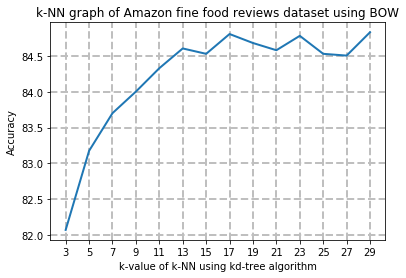

In [0]:
# Please write all the code with proper documentation
# final datapoint are in list preprocessed_reviews and their label in final['score']
# splitting datapoints to test and train sets
k = k_list
vect =  CountVectorizer(min_df=10, max_features=500)
params = {'n_neighbors':k, 'algorithm': ['kd_tree']}
scoring='roc_auc'
bow_kdtree_estimations = knn_estimator(preprocessed_reviews, final['Score'], vect, k, params, 3, scoring, 'BoW kd_tree')

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

100%|██████████| 15/15 [03:11<00:00, 12.76s/it]


[[1, 81.9458542713568], [3, 84.02701005025126], [5, 84.32776381909548], [7, 84.32814070351759], [9, 84.37839195979899], [11, 84.32814070351759], [13, 84.35326633165829], [15, 84.35326633165829], [17, 84.35326633165829], [19, 84.35326633165829], [21, 84.35326633165829], [23, 84.35326633165829], [25, 84.35326633165829], [27, 84.35326633165829], [29, 84.35326633165829]]

k-NN using kd_tree best model: 9-NN, With Accuracy: 84.38%


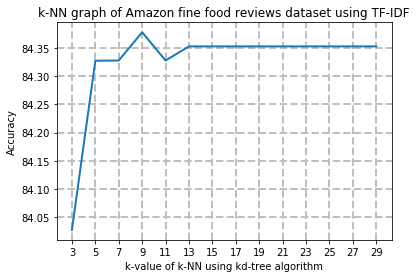

In [0]:
# Please write all the code with proper documentation
# final datapoint are in list preprocessed_reviews and their label in final['score']
# splitting datapoints to test and train sets

k = k_list
vect =  TfidfVectorizer(min_df=10, max_features=500)
params = {'n_neighbors':k, 'algorithm': ['kd_tree']}
scoring='roc_auc'
tfidf_kdtree_estimations = knn_estimator(preprocessed_reviews, final['Score'], vect, k, params, 3, scoring, 'Tf-Idf kd_tree')

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

100%|██████████| 15/15 [00:08<00:00,  1.56it/s]

[[1, 74.94924623115577], [3, 81.39422110552765], [5, 82.37110552763819], [7, 83.34937185929648], [9, 83.62537688442211], [11, 83.82575376884422], [13, 83.85100502512563], [15, 84.02650753768845], [17, 84.15201005025126], [19, 84.25251256281408], [21, 84.20251256281406], [23, 84.22776381909549], [25, 84.32801507537688], [27, 84.15251256281408], [29, 84.15251256281408]]

k-NN using kd_tree best model: 25-NN, With Accuracy: 84.33%


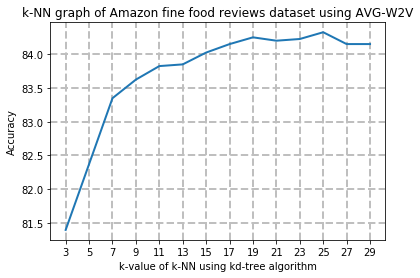

In [0]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, kd_tree
import time

x_train, x_test, y_train, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.20, shuffle=False, stratify=None)

t = time.time()

i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
    

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


print('Time consumed in {} vectorization= {:.2f} seconds'.format('Avg W2V', time.time()-t))


import multiprocessing
jobs = multiprocessing.cpu_count()
t = time.time()
knn =KNeighborsClassifier()
parameters = {'n_neighbors':k_list, 'algorithm': ['brute']}
clf = GridSearchCV(knn, parameters, cv=3, scoring='roc_auc', verbose=10, n_jobs=jobs, return_train_score=True)
clf.fit(sent_vectors, y_train)
print('Time consumed in GridsearchCV classifier= {:.2f} seconds'.format(time.time()-t))

avgw2v_kdtree_estimations = clf.cv_results_

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()  

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

100%|██████████| 15/15 [00:07<00:00,  1.80it/s]

[[1, 75.95138190954773], [3, 79.91419597989949], [5, 81.94522613065327], [7, 82.89836683417086], [9, 83.50100502512564], [11, 84.17738693467336], [13, 84.25276381909548], [15, 84.27788944723618], [17, 84.22751256281407], [19, 84.30276381909547], [21, 84.25276381909548], [23, 84.30301507537689], [25, 84.32814070351759], [27, 84.32814070351759], [29, 84.35326633165829]]

k-NN using kd_tree best model: 29-NN, With Accuracy: 84.35%


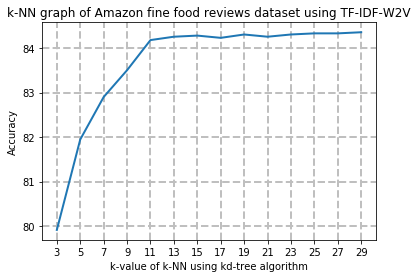

In [0]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, kd_tree
import time

x_train, x_test, y_train, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.20, shuffle=False, stratify=None)

t = time.time()

i=0
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())



# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


print('Time consumed in {} vectorization= {:.2f} seconds'.format('Avg W2V', time.time()-t))


import multiprocessing
jobs = multiprocessing.cpu_count()
t = time.time()
knn =KNeighborsClassifier()
parameters = {'n_neighbors':list(range(1, 4, 2)), 'algorithm': ['brute']}
clf = GridSearchCV(knn, parameters, cv=3, scoring='roc_auc', verbose=10, n_jobs=jobs, return_train_score=True)
clf.fit(tfidf_sent_vectors, y_train)
print('Time consumed in GridsearchCV classifier= {:.2f} seconds'.format(time.time()-t))


tfidfw2v_kdtree_extimations = clf.cv_results_


train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()  

100%|██████████| 15/15 [00:01<00:00,  7.09it/s]



k-NN using kd_tree best model: 13-NN, With Accuracy: 81.66%


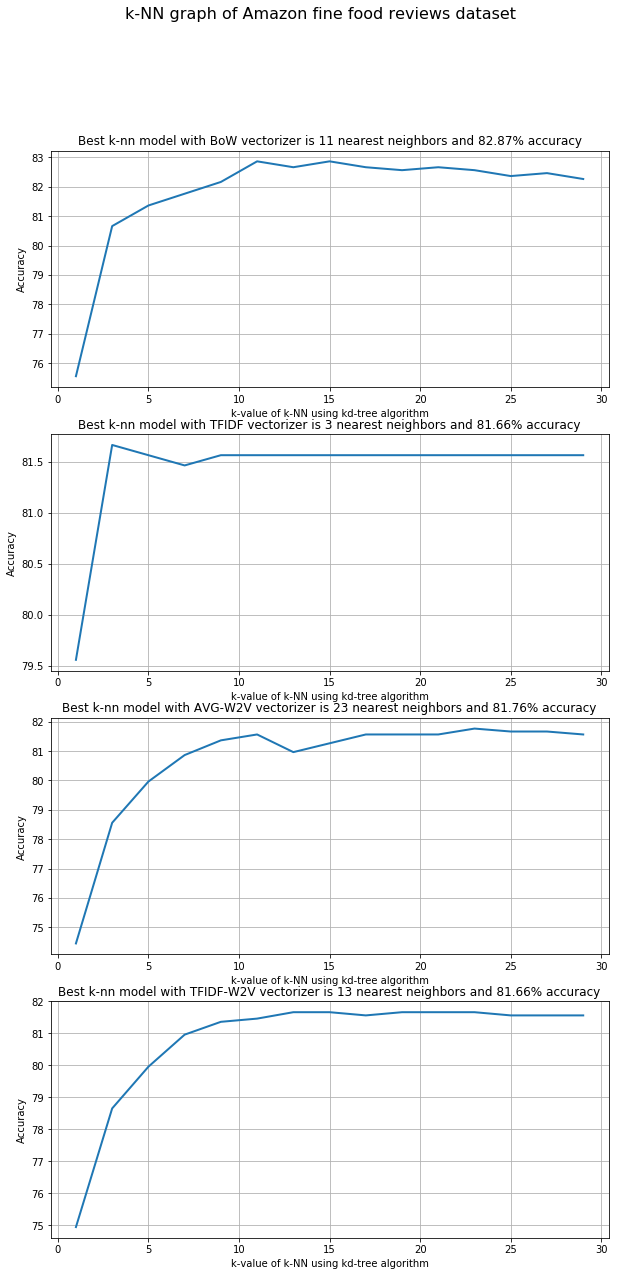

# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

#1. Accuray raises as per k value increase in k-NN models
#2. Only TF-IDF is showing better accuracy in lower values of nearest neighbors models
#3. I have used 10 fold cross validation and accuracy graph is based on cross validation
#4. Accuracy is nearly same for brute-force and kd-tree but kd-tree was comparatively faster
#4. I have used 80% of all data for training and cross validation which becomes 60% train and 20% cross validation data, this gave me nearly 84% accuracy
#5. While using 80% of training data and other 20% as test data without cross validation accuracy is 81.66 
#6. Final conclusion: using 10 fold cross validation raised accuracy by 3% as expected